In [329]:
from sphedron import Icosphere, UniformMesh
from sphedron.transfer import MeshTransfer
from sphedron.extra import get_mesh_landmask
from sphedron.extra import plot_2d_mesh
import matplotlib.pyplot as plt
import numpy as np

In [330]:
factor = 32
ico_mesh = Icosphere(refine_factor=factor)
uni_mesh = UniformMesh(resolution=1)

print(ico_mesh)
print(uni_mesh)

Mesh has: #nodes: 10242
          #faces: 20480
          #edges: 61440
          #edges_unique: 30720
          metadata: {'factor': 32}
Mesh has: #nodes: 65160
          #faces: 65160
          #edges: 195480
          #edges_unique: 65160
          metadata: {}


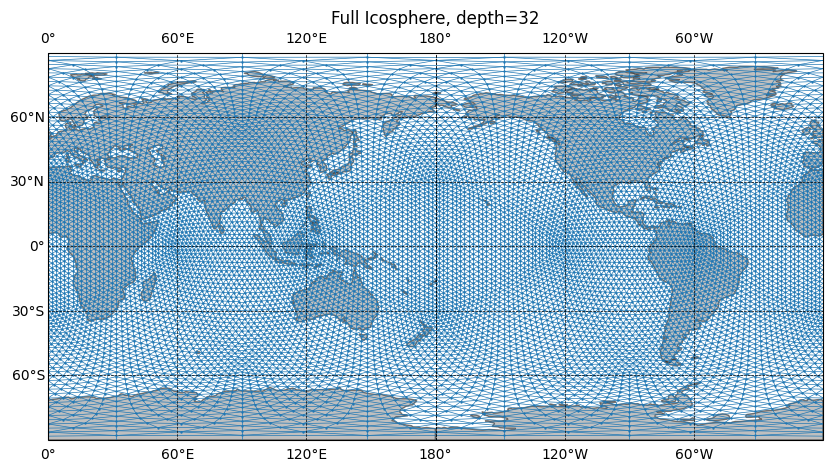

In [331]:
plot_2d_mesh(
    ico_mesh,
    title=f"Full Icosphere, depth={ico_mesh.metadata['factor']}",
    scatter=True,
    s=0.5,
)

In [332]:
ico_land_mask = get_mesh_landmask(ico_mesh)
ico_mesh.mask_nodes(ico_land_mask)

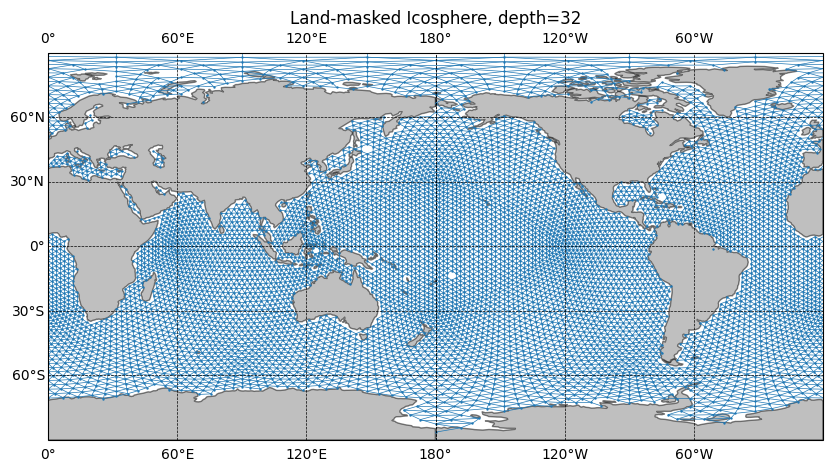

In [333]:
plot_2d_mesh(
    ico_mesh,
    title=f"Land-masked Icosphere, depth={ico_mesh.metadata['factor']}",
    scatter=True,
    s=0.5,
)

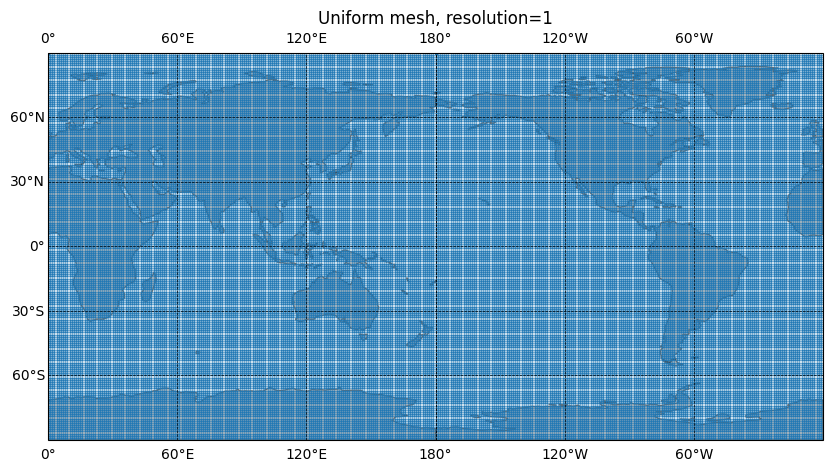

In [334]:
plot_2d_mesh(
    uni_mesh,
    title=f"Uniform mesh, resolution={uni_mesh.resolution}",
    scatter=True,
    s=0.5,
)

The mesh nodes are in xyz, let's create a test map where the values are |x|.

In [335]:
ico_values = np.abs(ico_mesh.nodes[:,0])

Now we want to transfer this map to the uniform mesh. We'll use a nearest neighbor transfer, where the value at each uniform node is the average of its 3 nearest nodes from the icosphere. MeshTransfer will only compute the neighbors once.

In [349]:
transfer = MeshTransfer(ico_mesh, uni_mesh, n_neighbors=5)

In [350]:
def weighted_func(w):
    min_w = np.min(w,axis=-1,keepdims=True) + 1e-16
    weights =  np.exp(-0.2*(w/min_w)**2)
    return weights / np.sum(weights, axis=-1, keepdims=True)

In [351]:
%%time
uniform_values = transfer.transfer(ico_values)

CPU times: user 65.2 ms, sys: 3.25 ms, total: 68.4 ms
Wall time: 10.7 ms


In [357]:
%%time
weighed_uniform_values = transfer.weighted_transfer(ico_values,weight_func=weighted_func)

CPU times: user 4.88 ms, sys: 2.09 ms, total: 6.97 ms
Wall time: 6.27 ms


The uniform values are flattened, we can reshape them as follows to get a 2D arrray:

In [358]:
uniform_values = uni_mesh.reshape(uniform_values)
weighed_uniform_values = uni_mesh.reshape(weighed_uniform_values)

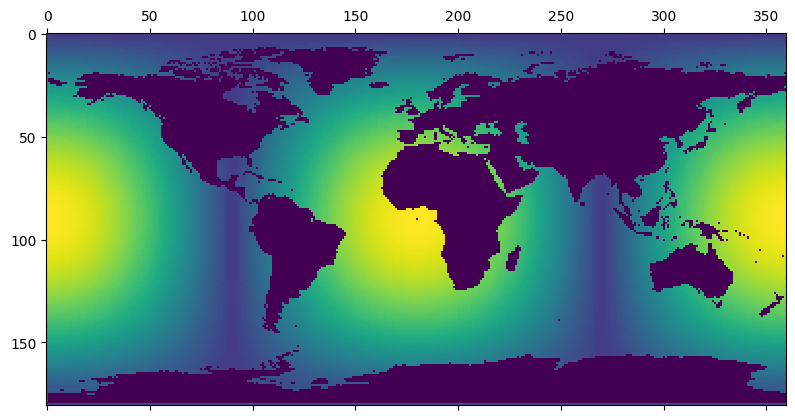

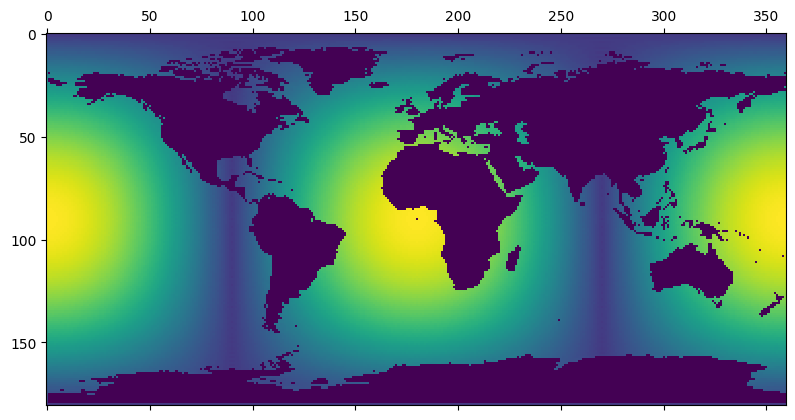

In [374]:
plt.matshow(uniform_values[::-1])
plt.show()
plt.matshow(weighed_uniform_values[::-1])

Let's now mask land on the uniform mesh as well: first we compute the mask, then reshape it

In [361]:
uniform_mask = uni_mesh.reshape(get_mesh_landmask(uni_mesh))

In [362]:
uniform_values[uniform_mask] = -0.2
weighed_uniform_values[uniform_mask] = -0.2

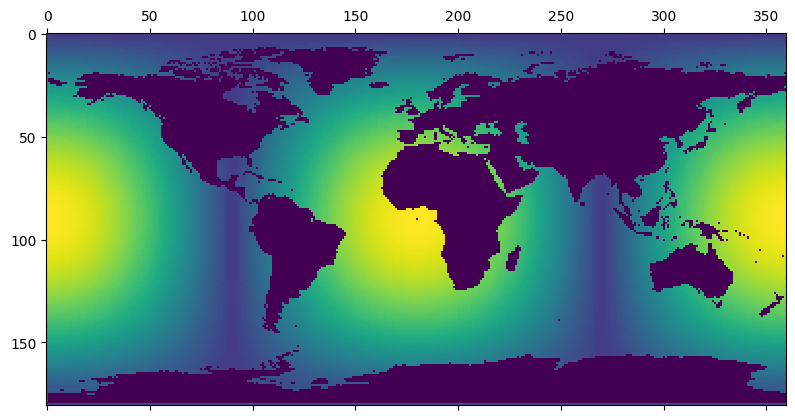

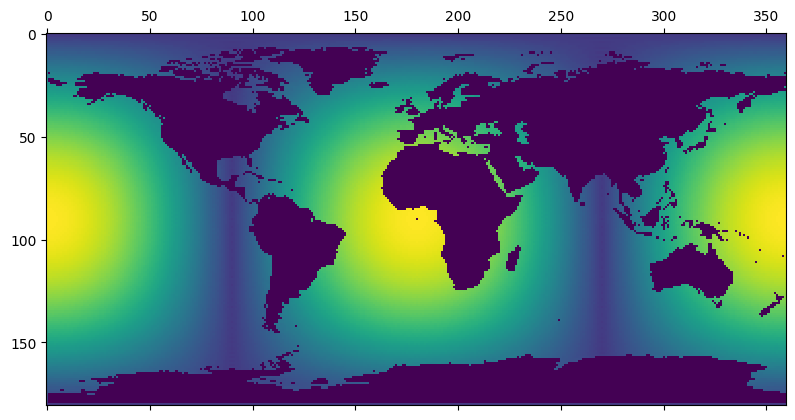

In [373]:
plt.matshow(uniform_values[::-1])
plt.show()
plt.matshow(weighed_uniform_values[::-1])

In [364]:
true_values = uni_mesh.reshape(np.abs(uni_mesh.nodes[:,0]))

In [365]:
np.linalg.norm((weighed_uniform_values-true_values)[~uniform_mask])

np.float64(0.7653098799034589)

In [366]:
np.linalg.norm((uniform_values-true_values)[~uniform_mask])

np.float64(2.103699462953429)

In [367]:
from scipy.interpolate import RBFInterpolator

ico_coords = ico_mesh.nodes
ico_values = np.abs(ico_mesh.nodes[:, 0])
uni_coords = uni_mesh.nodes


interpolated_values = RBFInterpolator(
    ico_coords,
    ico_values,
    neighbors=5,
    smoothing=0.1,
)(uni_coords)


In [368]:
interpolated_values = uni_mesh.reshape(interpolated_values)

In [369]:
np.linalg.norm((interpolated_values-true_values)[~uniform_mask])

np.float64(0.32493005606554143)

In [371]:
interpolated_values[uniform_mask] = -0.2

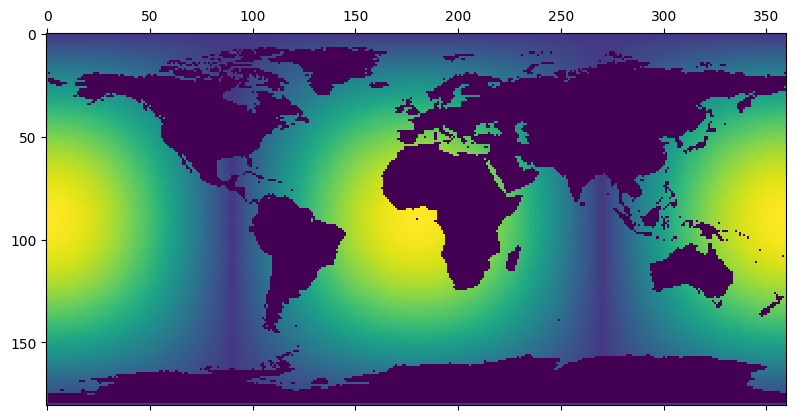

In [372]:
plt.matshow(interpolated_values[::-1])